In [1]:
from importlib import reload
import sys
import os
sys.path.insert(0, './..')
sys.path.insert(0, './../scripts')

In [2]:
from tqdm import tqdm
import numpy as np
from scipy.stats import spearmanr,kendalltau,permutation_test,kstest,bernoulli,poisson,zscore
import matplotlib as mpl
import matplotlib.pyplot as plt

import burst_func as bf
import plot_func as pf

# Model Visual Response to Moving Light/Dark Edge

We'll model visual responses similarly to how we modeled geniculate waves, ie as bursts of activity traveling like a moving wave. However, we'll offset the timing of the ON vs OFF bursts to mimic a moving light and dark bar in the visual scene

The goal is to get same-type correlations of $0.52$ and opposite-type correlations of $-0.38$

In [45]:
reload(bf)

nwaves = 10
nbar = 40
ngrid = 20
bar_len = 0.99/np.sqrt(2)
res = 1.001*bar_len/nbar/np.sqrt(2)

ss,ts = np.meshgrid(np.linspace(0.5/nbar,1-0.5/nbar,nbar),np.linspace(0.5/nbar,1-0.5/nbar,nbar))
ss,ts = ss.flatten(),ts.flatten()
xs,ys = np.meshgrid(np.linspace(0.5/ngrid,1-0.5/ngrid,ngrid),np.linspace(0.5/ngrid,1-0.5/ngrid,ngrid))
xs,ys = xs.flatten(),ys.flatten()

in_rf = np.sqrt((xs-0.5)**2 + (ys-0.5)**2) < 0.5/np.sqrt(2)
xs,ys = xs[in_rf],ys[in_rf]
n_in_rf = len(xs)

rng = np.random.default_rng(0)

oris = rng.uniform(0,2*np.pi,nwaves)

pass_times = np.zeros((nwaves,n_in_rf))

for idx,ori in enumerate(oris):
    bar_to_box = bf.gen_mov_bar(0.5*(np.ones(2) - bar_len*np.array([np.cos(ori),np.sin(ori)])),
                             ori,bar_len,bar_len)
    bar_pos = bar_to_box(ss,ts)
    pass_times[idx] = bf.bar_pass_time(bar_pos,np.array([xs,ys]).T,ts,res)
    
leading_on = rng.choice([1,-1],nwaves)

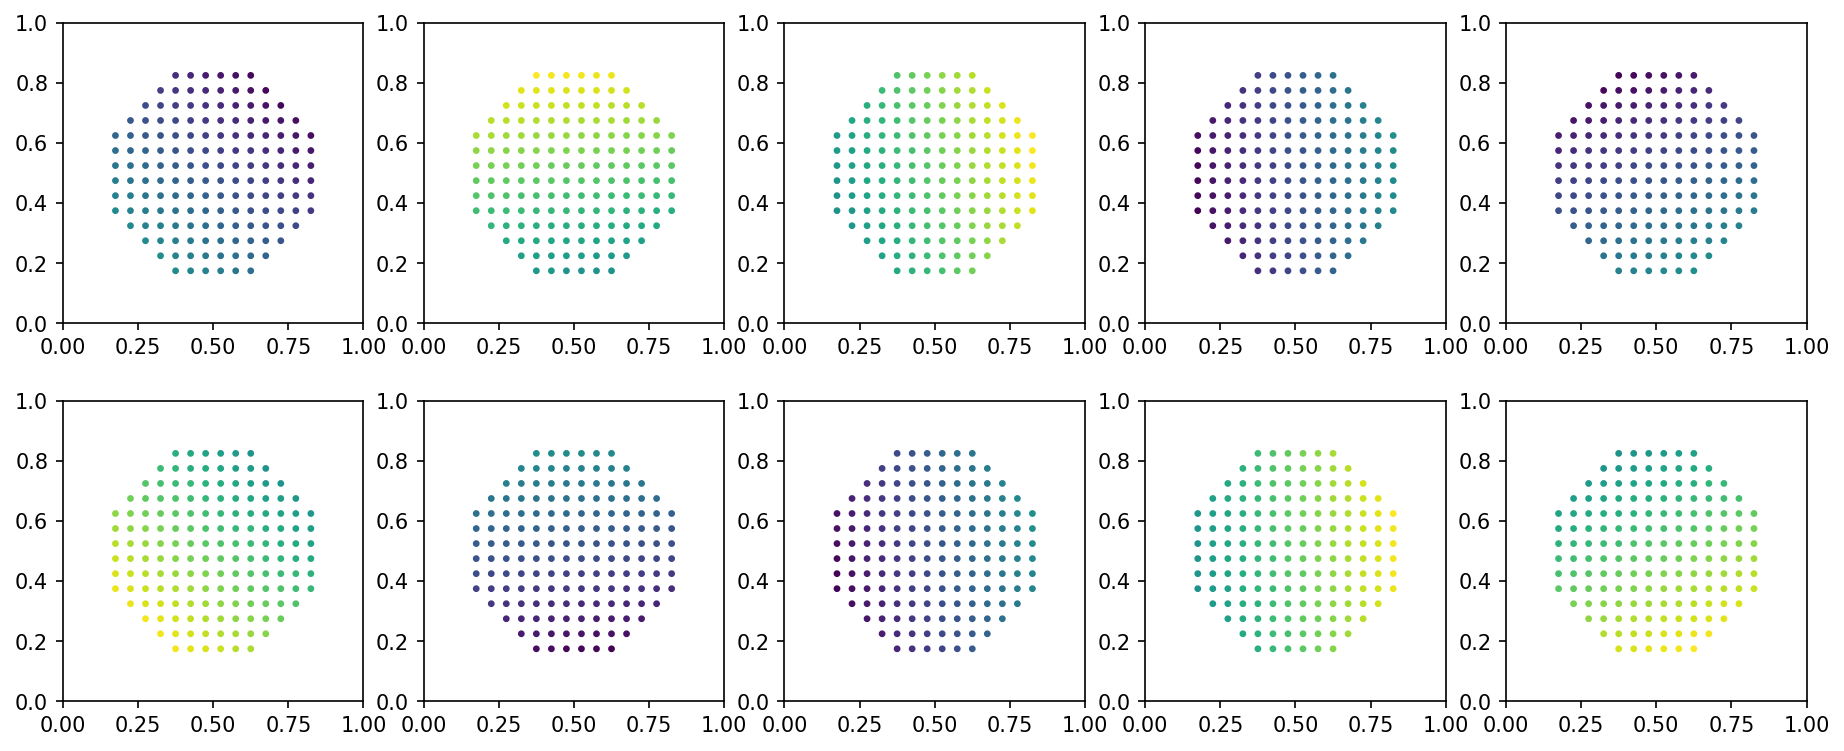

In [46]:
fig,axs = plt.subplots(2,5,figsize=(15,6),dpi=150)

for idx in range(5):
    colors = mpl.colormaps['viridis'](0.25 + 0.5*pass_times[idx] - 0.25*leading_on[idx])
    axs[0,idx].scatter(xs,ys,s=5,c=colors)
    
    colors = mpl.colormaps['viridis'](0.25 + 0.5*pass_times[idx] + 0.25*leading_on[idx])
    axs[1,idx].scatter(xs,ys,s=5,c=colors)

    for i in range(2):
        axs[i,idx].set_xlim([0,1])
        axs[i,idx].set_ylim([0,1])
        axs[i,idx].set_aspect('equal')

In [98]:
rm = 20 # Hz
rb = 1 # Hz
dt = 0.1 # s
ibi = 3.3 # s
dur = 1.1/2 # s

burst_times = np.zeros((nwaves,2*n_in_rf))

burst_times[:,:n_in_rf] = ibi*(5/12 + 1/6*pass_times - 1/12*leading_on[:,None] + np.arange(nwaves)[:,None])
burst_times[:,n_in_rf:] = ibi*(5/12 + 1/6*pass_times + 1/12*leading_on[:,None] + np.arange(nwaves)[:,None])

ts = np.linspace(0,ibi*nwaves,int(np.round(ibi*nwaves/dt))+1)

spike_ls = np.zeros((len(ts),2*n_in_rf))
spike_ls += rb * dt

for widx in range(nwaves):
    for cidx in range(2*n_in_rf):
        spike_ls[:,cidx] += (rm-rb)*np.exp(-(np.abs(ts-burst_times[widx,cidx])/(0.5*dur))**2) * dt
spike_ls = np.fmax(1e-5,spike_ls)

In [80]:
dists = np.sqrt((xs[:,None]-xs[None,:])**2 + (ys[:,None]-ys[None,:])**2)
dist_corrs = np.exp(-0.5*(dists/0.05)**2)

rs = 0.0
ro = -1

spike_rs = np.block([[rs*dist_corrs,ro*dist_corrs],
                     [ro*dist_corrs,rs*dist_corrs]])
np.fill_diagonal(spike_rs,1)
spike_rs = spike_rs[None,:,:] * np.ones((len(ts),1,1))

us = np.linspace(0,1,501)[1:-1]
ns = np.zeros((len(us),2*n_in_rf))

for idx,l in tqdm(enumerate(spike_ls)):
    ns[:] = poisson.ppf(us[:,None],l[None,:])
    ns[:] = zscore(ns,axis=0)

    # lo_bnd = np.einsum('ijk,ijl->jkl',ns,ns[::-1,:,:]) / len(us)
    # up_bnd = np.einsum('ijk,ijl->jkl',ns,ns) / len(us)
    lo_bnd = ns.T@ns[::-1,:] / len(us)
    up_bnd = ns.T@ns / len(us)

    spike_rs[idx] = np.fmax(np.fmin(spike_rs[idx],up_bnd),lo_bnd)
    np.fill_diagonal(spike_rs[idx],1)

331it [00:39,  8.29it/s]


In [81]:
reload(bf)

rng = np.random.default_rng(0)

spikes = np.zeros((len(ts),2*n_in_rf),np.ushort)

for idx,l,r in tqdm(zip(range(len(ts)),spike_ls,spike_rs)):
    spikes[idx] = bf.gen_corr_pois_vars(l,r,rng)[:,0]

0it [00:00, ?it/s]

331it [01:36,  3.41it/s]


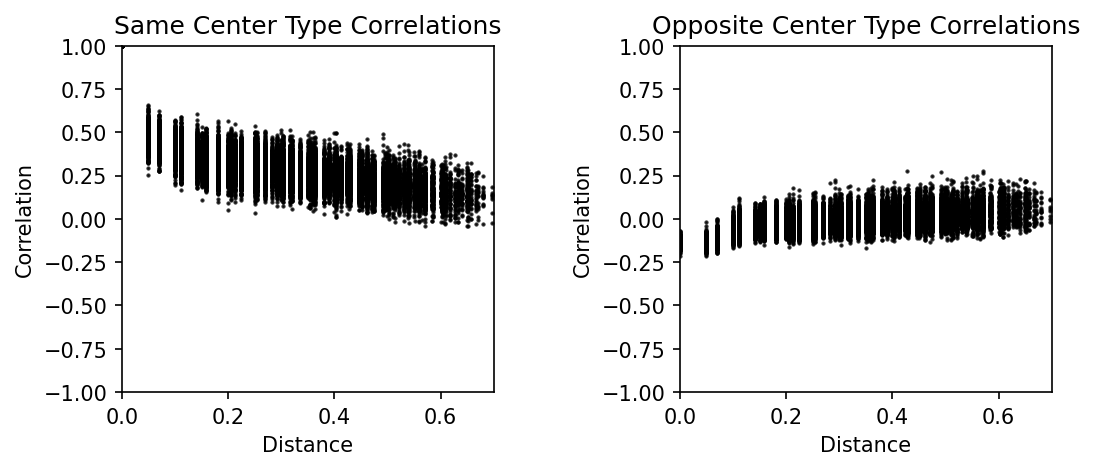

In [82]:
dists = np.sqrt((xs[:,None]-xs[None,:])**2 + (ys[:,None]-ys[None,:])**2)
corrs = np.corrcoef(spikes.T)

fig,axs = plt.subplots(1,2,figsize=(8,3),dpi=150)
fig.subplots_adjust(wspace=0.5)

axs[0].scatter(dists,corrs[:n_in_rf,:n_in_rf],s=1,color='k',alpha=0.5)
axs[0].scatter(dists,corrs[n_in_rf:,n_in_rf:],s=1,color='k',alpha=0.5)

axs[1].scatter(dists,corrs[:n_in_rf,n_in_rf:],s=1,color='k',alpha=0.5)
axs[1].scatter(dists,corrs[n_in_rf:,:n_in_rf],s=1,color='k',alpha=0.5)

axs[0].set_title('Same Center Type Correlations')
axs[1].set_title('Opposite Center Type Correlations')

for idx in range(2):
    axs[idx].set_xlabel('Distance')
    axs[idx].set_ylabel('Correlation')
    
    axs[idx].set_xlim(0,bar_len)
    axs[idx].set_ylim(-1,1)

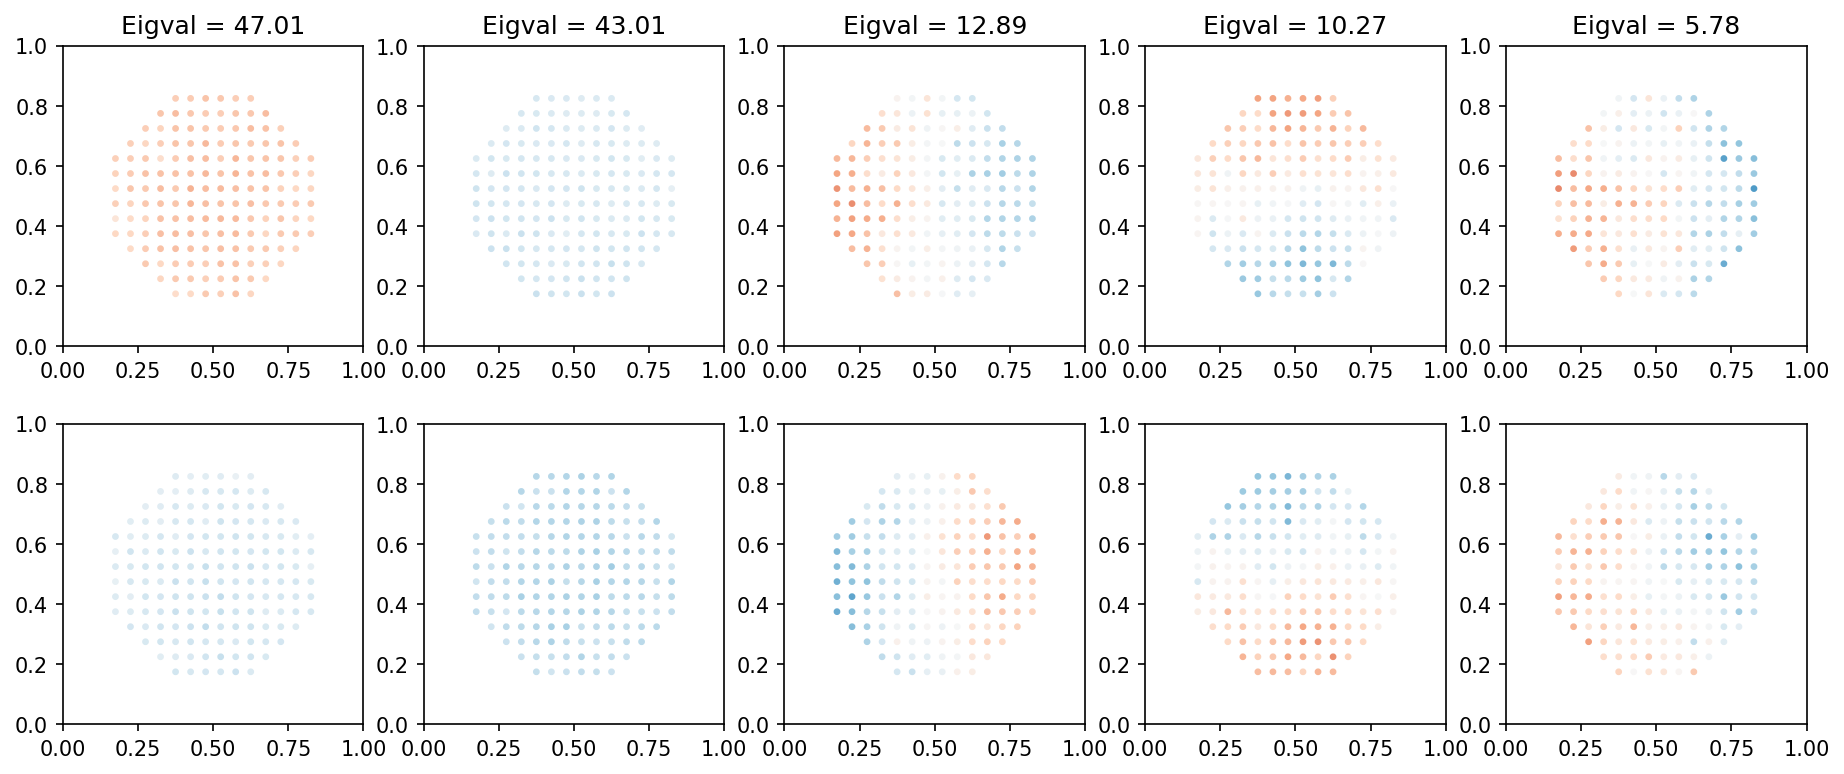

In [83]:
vals,vecs = np.linalg.eigh(corrs)

fig,axs = plt.subplots(2,5,figsize=(15,6),dpi=150)

for idx in range(5):
    max_vec_val = np.max(np.abs(vecs))
    colors = mpl.colormaps['RdBu'](0.5 + 0.5*vecs[:n_in_rf,-(idx+1)]/max_vec_val)
    axs[0,idx].scatter(xs,ys,s=5,c=colors)
    
    colors = mpl.colormaps['RdBu'](0.5 + 0.5*vecs[n_in_rf:,-(idx+1)]/max_vec_val)
    axs[1,idx].scatter(xs,ys,s=5,c=colors)

    for i in range(2):
        axs[i,idx].set_xlim([0,1])
        axs[i,idx].set_ylim([0,1])
        axs[i,idx].set_aspect('equal')
        
    axs[0,idx].set_title('Eigval = {:.2f}'.format(vals[-(idx+1)]))

In [84]:
print(np.mean(corrs[:n_in_rf,:n_in_rf][np.logical_and(0 < dists,dists < 0.1)]))
print(np.mean(corrs[:n_in_rf,n_in_rf:][dists < 0.1]))

0.45015036352148785
-0.11413271856830434


In [4]:
import pickle

spikes = np.zeros((1,2*n_in_rf),np.ushort)
for i in range(25):
    with open('./../results/lgn_vis_spikes_nw={:d}_ng={:d}/seed={:d}.pkl'.format(60,20,i), 'rb') as handle:
        res_dict = pickle.load(handle)
    spikes = np.concatenate((spikes,res_dict['spikes']),axis=0)

In [5]:
print(np.max(spikes))
print(np.mean(spikes))
print(np.std(spikes))

8
0.23629080607233496
0.5608561733624065


In [6]:
%matplotlib Tk

from matplotlib.animation import FuncAnimation

fig, axs = plt.subplots(1,2,figsize=(10,4),dpi=150)
sc_n = axs[0].scatter(xs,ys,s=5,cmap='viridis',norm=mpl.colors.Normalize(vmin=0,vmax=2),c=np.zeros(n_in_rf))
sc_f = axs[1].scatter(xs,ys,s=5,cmap='viridis',norm=mpl.colors.Normalize(vmin=0,vmax=2),c=np.zeros(n_in_rf))

def init():
    for i in range(2):
        axs[i].set_xlim(0,1)
        axs[i].set_ylim(0,1)
        axs[i].tick_params(left=False, right=False, labelleft=False, labelbottom=False, bottom=False)
        axs[i].set_aspect('equal')
    return sc_n,sc_f,

def update(frame):
    sc_n.set_array(np.mean(res_dict['spikes'][5*frame:5*frame+5,:n_in_rf],0))
    sc_f.set_array(np.mean(res_dict['spikes'][5*frame:5*frame+5,n_in_rf:],0))
    return sc_n,sc_f,

ani = FuncAnimation(fig, update, frames=len(res_dict['spikes']//5),
                    init_func=init, blit=True, interval=1000, repeat_delay=1000, repeat=True)
# plt.show()

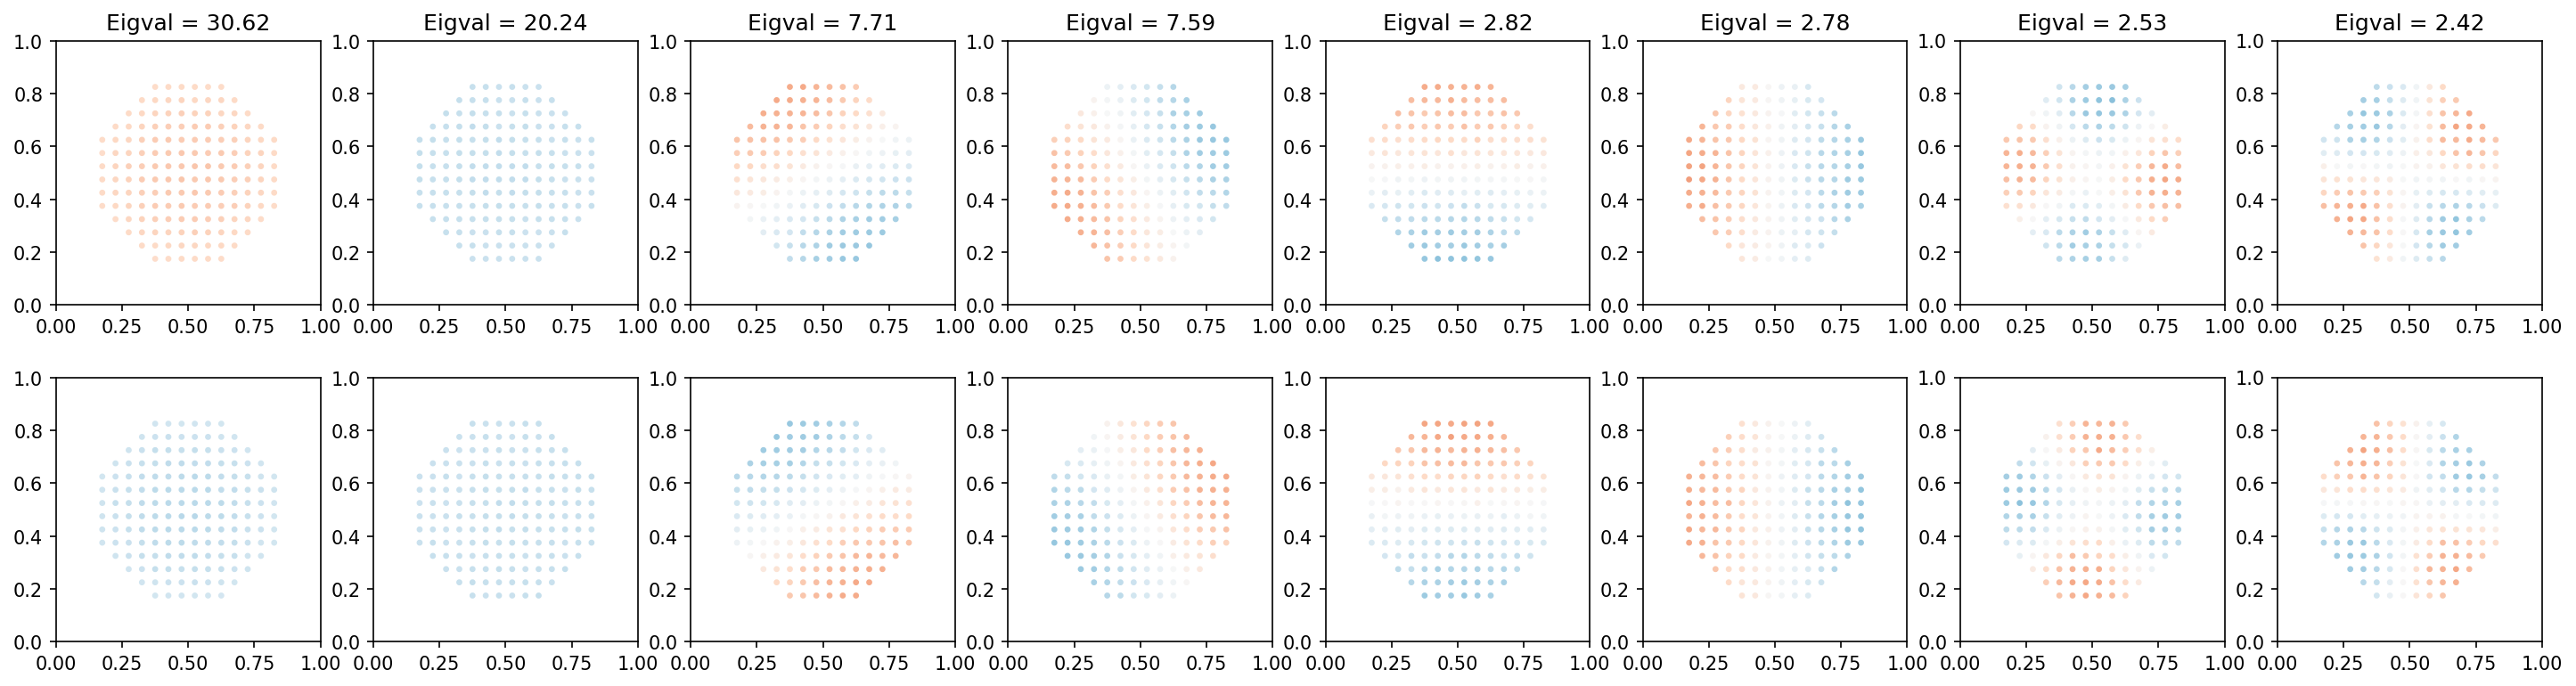

In [5]:
corrs = np.corrcoef(spikes.T)
vals,vecs = np.linalg.eigh(corrs)

fig,axs = plt.subplots(2,8,figsize=(24,6),dpi=150)

for idx in range(8):
    max_vec_val = np.max(np.abs(vecs))
    colors = mpl.colormaps['RdBu'](0.5 + 0.5*vecs[:n_in_rf,-(idx+1)]/max_vec_val)
    axs[0,idx].scatter(xs,ys,s=5,c=colors)
    
    colors = mpl.colormaps['RdBu'](0.5 + 0.5*vecs[n_in_rf:,-(idx+1)]/max_vec_val)
    axs[1,idx].scatter(xs,ys,s=5,c=colors)

    for i in range(2):
        axs[i,idx].set_xlim([0,1])
        axs[i,idx].set_ylim([0,1])
        axs[i,idx].set_aspect('equal')
        
    axs[0,idx].set_title('Eigval = {:.2f}'.format(vals[-(idx+1)]))

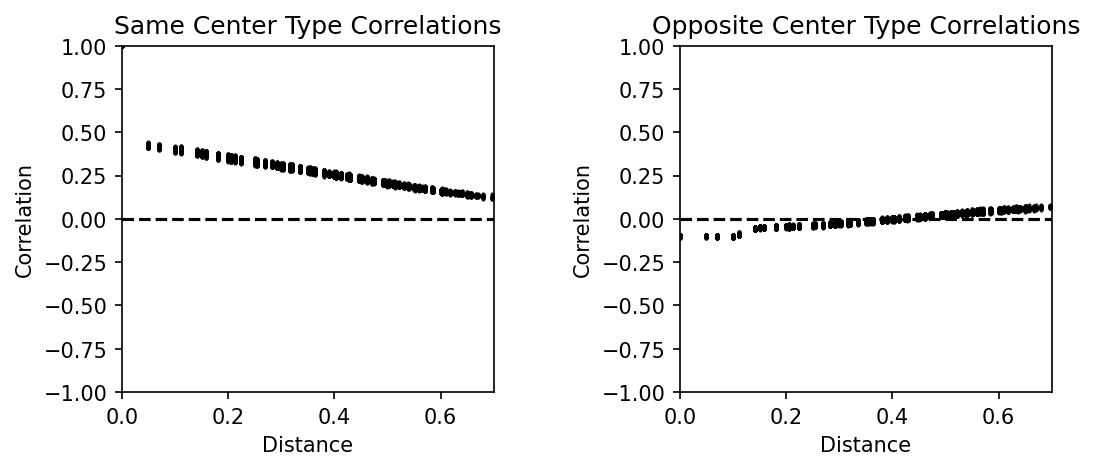

In [92]:
dists = np.sqrt((xs[:,None]-xs[None,:])**2 + (ys[:,None]-ys[None,:])**2)

fig,axs = plt.subplots(1,2,figsize=(8,3),dpi=150)
fig.subplots_adjust(wspace=0.5)

axs[0].scatter(dists,corrs[:n_in_rf,:n_in_rf],s=1,color='k',alpha=0.5)
axs[0].scatter(dists,corrs[n_in_rf:,n_in_rf:],s=1,color='k',alpha=0.5)

axs[1].scatter(dists,corrs[:n_in_rf,n_in_rf:],s=1,color='k',alpha=0.5)
axs[1].scatter(dists,corrs[n_in_rf:,:n_in_rf],s=1,color='k',alpha=0.5)

axs[0].set_title('Same Center Type Correlations')
axs[1].set_title('Opposite Center Type Correlations')

for idx in range(2):
    axs[idx].set_xlabel('Distance')
    axs[idx].set_ylabel('Correlation')
    
    axs[idx].set_xlim(0,bar_len)
    axs[idx].set_ylim(-1,1)
    
    axs[idx].axhline(0,color='k',linestyle='--')

In [18]:
import pickle

spikes = np.zeros((1,2*ngrid**2),np.ushort)
for i in range(25):
    with open('./../results/2d_lgn_vis_spikes_nw={:d}_ns={:d}_ng={:d}/seed={:d}.pkl'.format(60,4,20,i), 'rb') as handle:
        res_dict = pickle.load(handle)
    spikes = np.concatenate((spikes,res_dict['spikes']),axis=0)

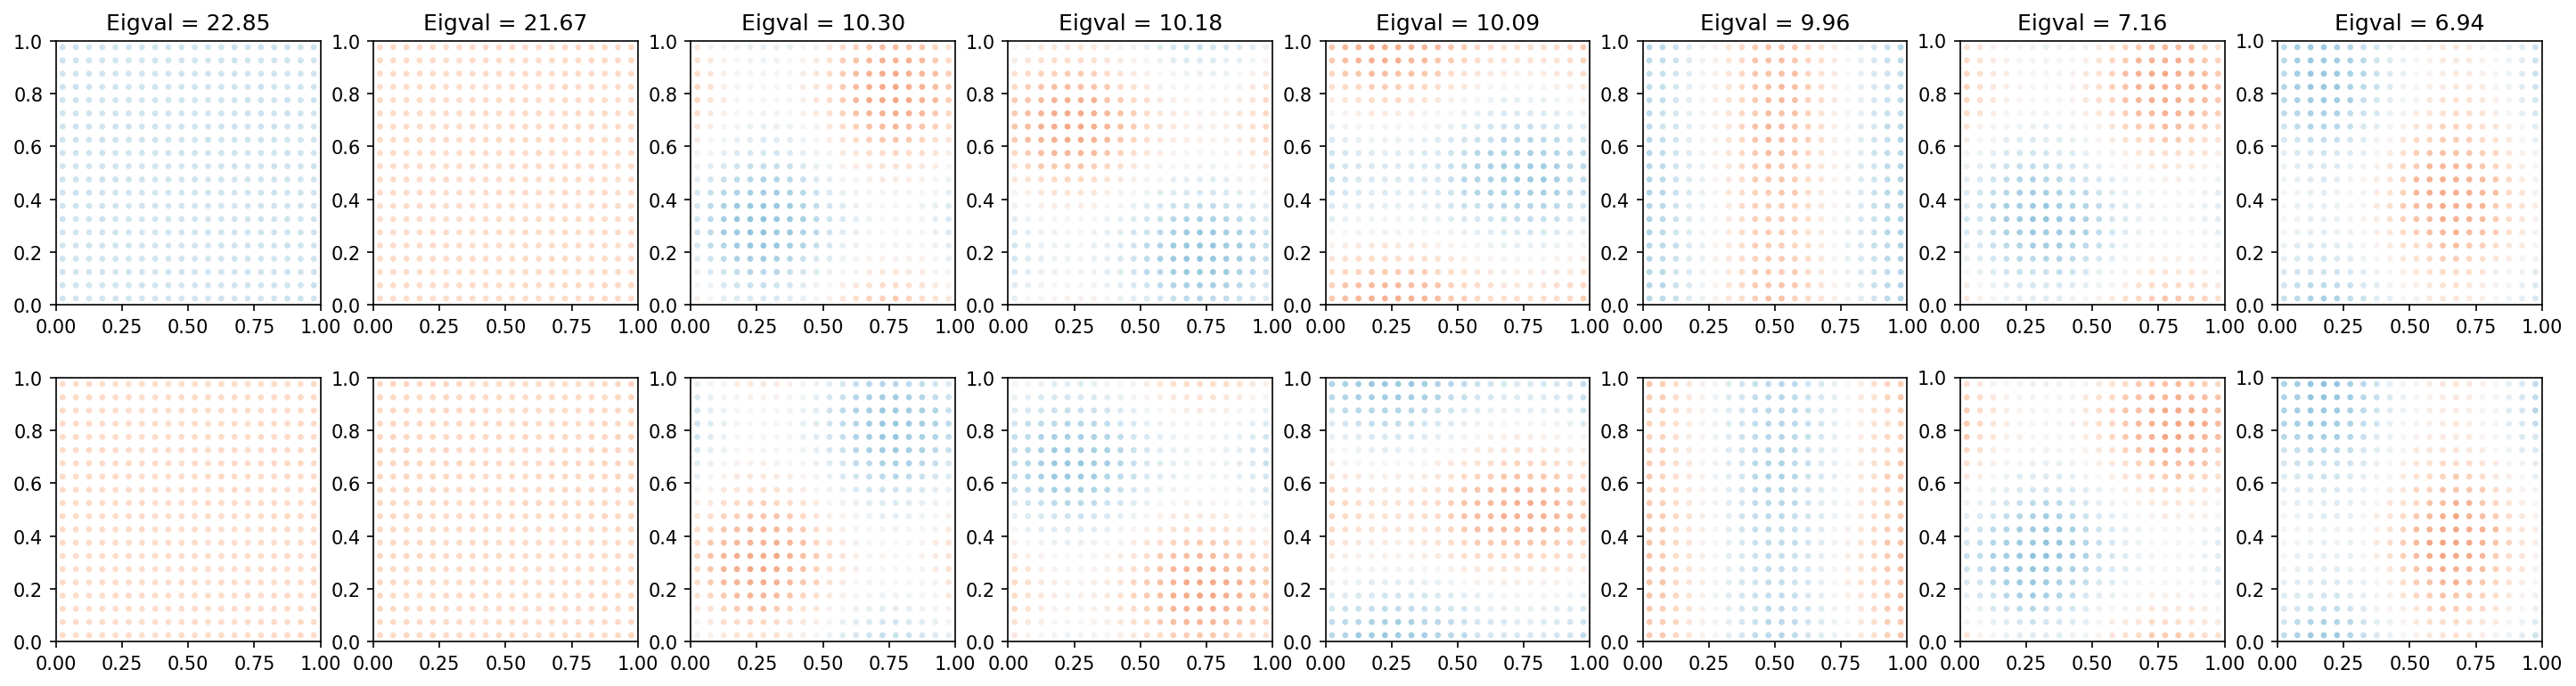

In [17]:
xs,ys = np.meshgrid(np.linspace(0.5/ngrid,1-0.5/ngrid,ngrid),
                    np.linspace(0.5/ngrid,1-0.5/ngrid,ngrid))
xs,ys = xs.flatten(),ys.flatten()
dists = np.sqrt(np.fmin(np.abs(xs[:,None]-xs[None,:]),
                        1-np.abs(xs[:,None]-xs[None,:]))**2 +\
                np.fmin(np.abs(ys[:,None]-ys[None,:]),
                        1-np.abs(ys[:,None]-ys[None,:]))**2)

corrs = np.corrcoef(spikes.T)
vals,vecs = np.linalg.eigh(corrs)

fig,axs = plt.subplots(2,8,figsize=(24,6),dpi=150)

for idx in range(8):
    max_vec_val = np.max(np.abs(vecs))
    colors = mpl.colormaps['RdBu'](0.5 + 0.5*vecs[:ngrid**2,-(idx+1)]/max_vec_val)
    axs[0,idx].scatter(xs,ys,s=5,c=colors)
    
    colors = mpl.colormaps['RdBu'](0.5 + 0.5*vecs[ngrid**2:,-(idx+1)]/max_vec_val)
    axs[1,idx].scatter(xs,ys,s=5,c=colors)

    for i in range(2):
        axs[i,idx].set_xlim([0,1])
        axs[i,idx].set_ylim([0,1])
        axs[i,idx].set_aspect('equal')
        
    axs[0,idx].set_title('Eigval = {:.2f}'.format(vals[-(idx+1)]))

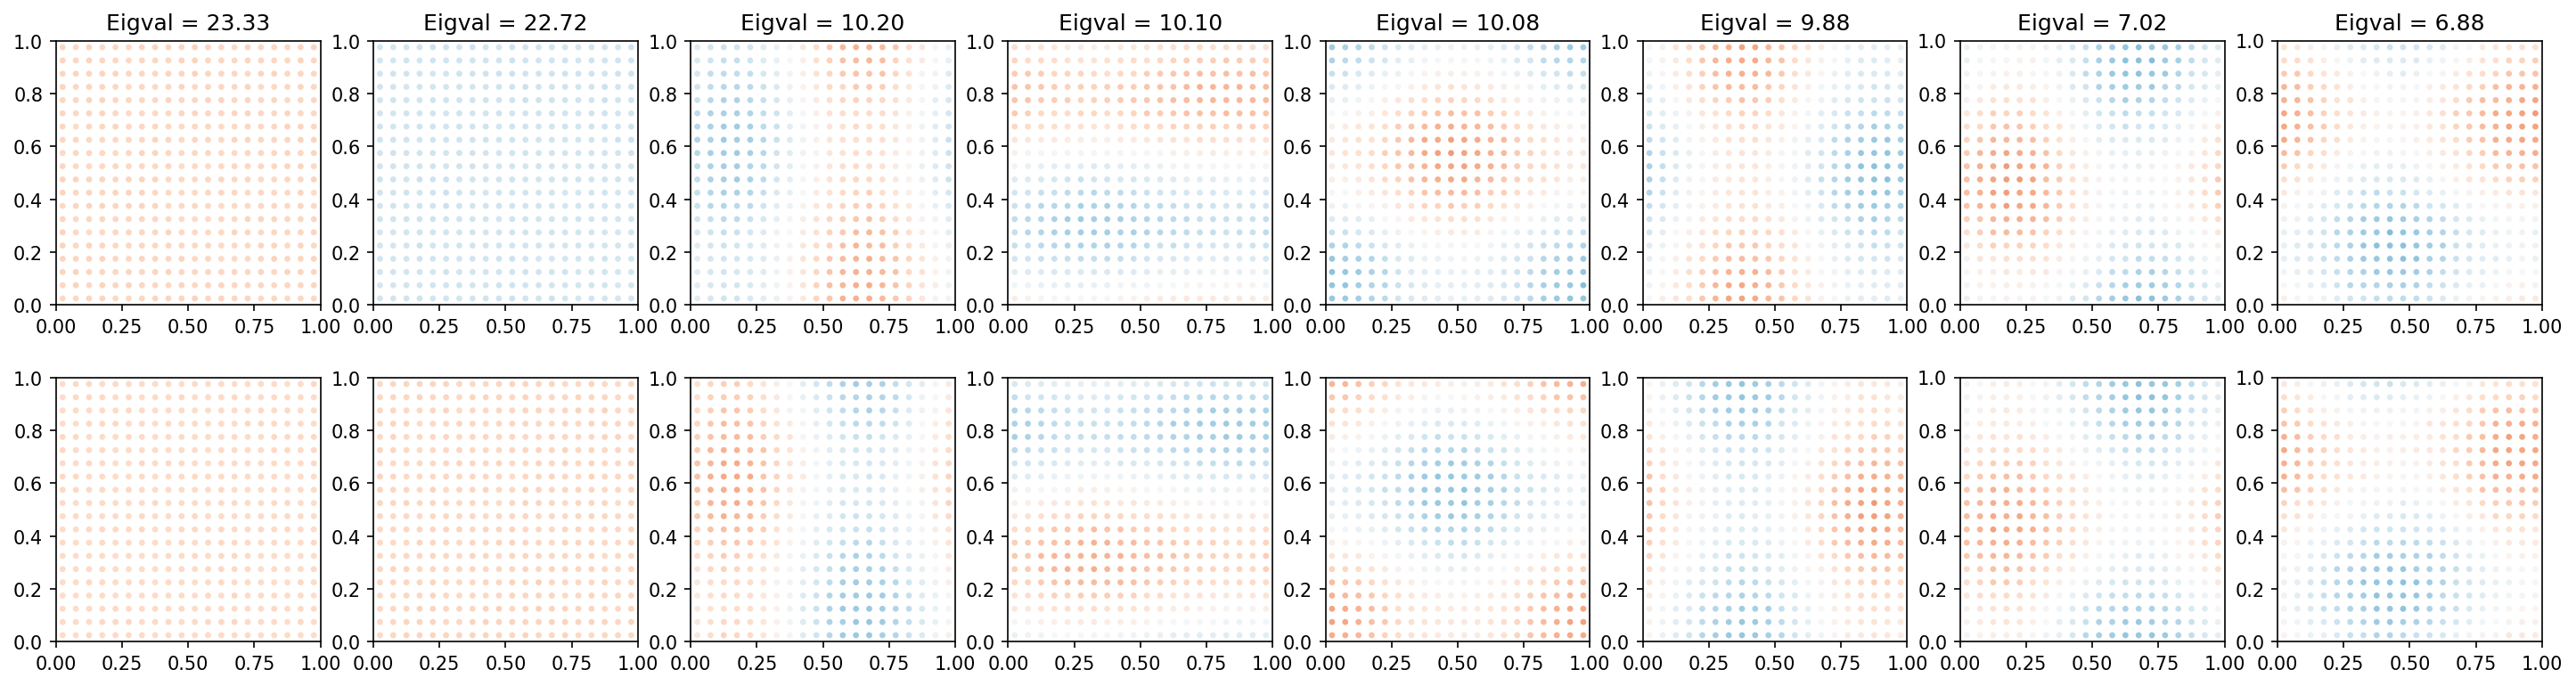

In [15]:
xs,ys = np.meshgrid(np.linspace(0.5/ngrid,1-0.5/ngrid,ngrid),
                    np.linspace(0.5/ngrid,1-0.5/ngrid,ngrid))
xs,ys = xs.flatten(),ys.flatten()
dists = np.sqrt(np.fmin(np.abs(xs[:,None]-xs[None,:]),
                        1-np.abs(xs[:,None]-xs[None,:]))**2 +\
                np.fmin(np.abs(ys[:,None]-ys[None,:]),
                        1-np.abs(ys[:,None]-ys[None,:]))**2)

corrs = np.corrcoef(spikes.T)
vals,vecs = np.linalg.eigh(corrs)

fig,axs = plt.subplots(2,8,figsize=(24,6),dpi=150)

for idx in range(8):
    max_vec_val = np.max(np.abs(vecs))
    colors = mpl.colormaps['RdBu'](0.5 + 0.5*vecs[:ngrid**2,-(idx+1)]/max_vec_val)
    axs[0,idx].scatter(xs,ys,s=5,c=colors)
    
    colors = mpl.colormaps['RdBu'](0.5 + 0.5*vecs[ngrid**2:,-(idx+1)]/max_vec_val)
    axs[1,idx].scatter(xs,ys,s=5,c=colors)

    for i in range(2):
        axs[i,idx].set_xlim([0,1])
        axs[i,idx].set_ylim([0,1])
        axs[i,idx].set_aspect('equal')
        
    axs[0,idx].set_title('Eigval = {:.2f}'.format(vals[-(idx+1)]))

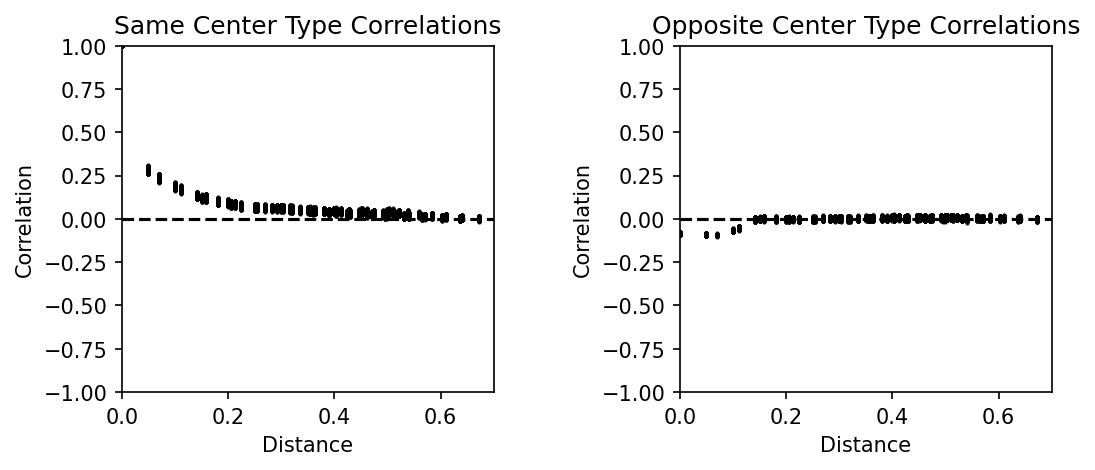

In [19]:
fig,axs = plt.subplots(1,2,figsize=(8,3),dpi=150)
fig.subplots_adjust(wspace=0.5)

axs[0].scatter(dists,corrs[:ngrid**2,:ngrid**2],s=1,color='k',alpha=0.5)
axs[0].scatter(dists,corrs[ngrid**2:,ngrid**2:],s=1,color='k',alpha=0.5)

axs[1].scatter(dists,corrs[:ngrid**2,ngrid**2:],s=1,color='k',alpha=0.5)
axs[1].scatter(dists,corrs[ngrid**2:,:ngrid**2],s=1,color='k',alpha=0.5)

axs[0].set_title('Same Center Type Correlations')
axs[1].set_title('Opposite Center Type Correlations')

for idx in range(2):
    axs[idx].set_xlabel('Distance')
    axs[idx].set_ylabel('Correlation')
    
    axs[idx].set_xlim(0,bar_len)
    axs[idx].set_ylim(-1,1)
    
    axs[idx].axhline(0,color='k',linestyle='--')

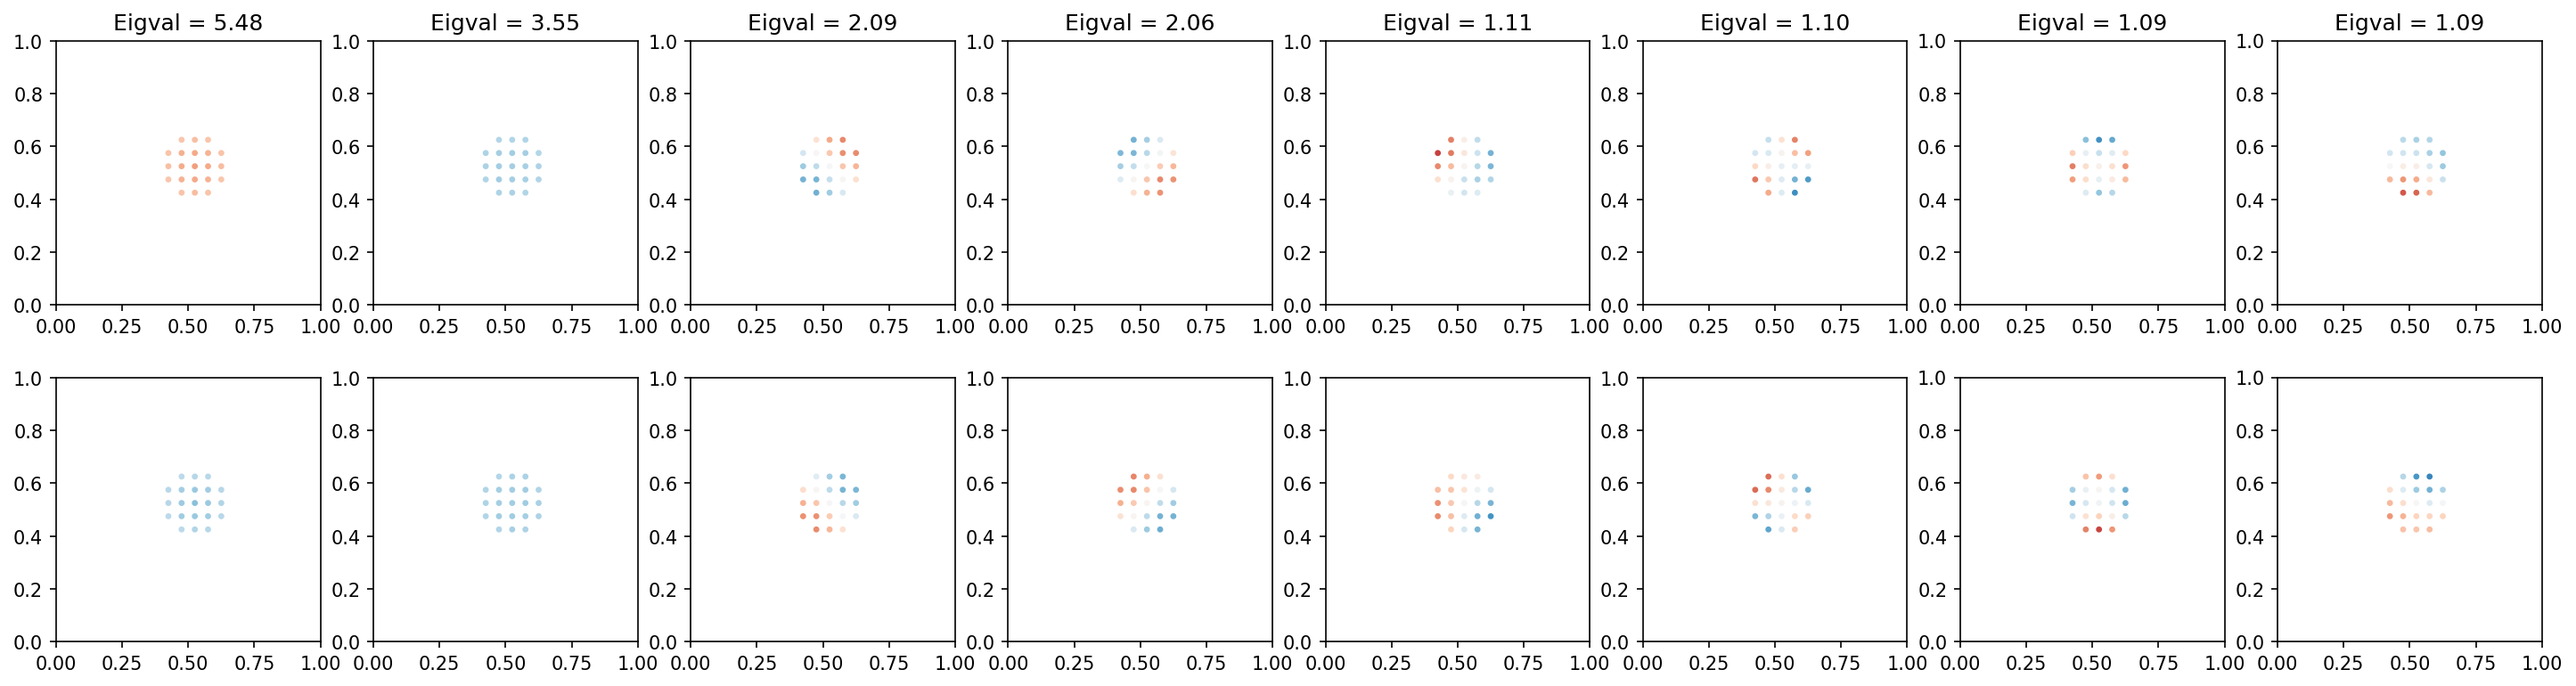

In [24]:
xs,ys = np.meshgrid(np.linspace(0.5/ngrid,1-0.5/ngrid,ngrid),
                    np.linspace(0.5/ngrid,1-0.5/ngrid,ngrid))
xs,ys = xs.flatten(),ys.flatten()

in_rf = np.sqrt((xs-0.525)**2 + (ys-0.525)**2) <= 1.5 * 0.08 * 1.0001
xs,ys = xs[in_rf],ys[in_rf]
n_in_rf = len(xs)

corrs = np.corrcoef(spikes[:,np.concatenate((in_rf,in_rf))].T)
vals,vecs = np.linalg.eigh(corrs)

fig,axs = plt.subplots(2,8,figsize=(24,6),dpi=150)

for idx in range(8):
    max_vec_val = np.max(np.abs(vecs))
    colors = mpl.colormaps['RdBu'](0.5 + 0.5*vecs[:n_in_rf,-(idx+1)]/max_vec_val)
    axs[0,idx].scatter(xs,ys,s=5,c=colors)
    
    colors = mpl.colormaps['RdBu'](0.5 + 0.5*vecs[n_in_rf:,-(idx+1)]/max_vec_val)
    axs[1,idx].scatter(xs,ys,s=5,c=colors)

    for i in range(2):
        axs[i,idx].set_xlim([0,1])
        axs[i,idx].set_ylim([0,1])
        axs[i,idx].set_aspect('equal')
        
    axs[0,idx].set_title('Eigval = {:.2f}'.format(vals[-(idx+1)]))